# Machine Learning models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_pickle('df_userID.pickle')
data.columns

Index(['Race', 'Date', 'RaceYear', 'RaceMonth', 'Category', 'Distance', 'Name',
       'Sex', 'Year', 'LivingPlace', 'Rank', 'Time', 'Pace', 'Place',
       'MinTemp', 'MaxTemp', 'Weather', 'RaceID', 'UserID'],
      dtype='object')

In [3]:
data.head()

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0
3,Kerzerslauf,sam. 18.03.2000,2000,3,F45,15.0,Ackermann Antoinette,F,1953.0,Alterswil,48,01:22:36.700000,00:05:30,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Ackermann Antoinette 1953.0
4,Kerzerslauf,sam. 18.03.2000,2000,3,F50,15.0,Ackermann Hedy,F,1946.0,Alterswil,42,01:23:29.300000,00:05:33,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Ackermann Hedy 1946.0


Notes: ML model for runners -> distinguish amatorials from professionals (per sex)
possible parameters:
- race (?)
- age
- pace
- year
- ...
Do unsupervised clustering; for viz purposes: plot living place in Switzerland

# Trial analysis: women, marathon

Split up by:
- sex
- quantized categories ( less 5, 5-15, 15-30, 30-60, more 60)

In [25]:
# partial dataframe
d1 = data[(data.Sex=='F') & (data.Distance>=30.0) & (data.Distance<60.0)][['UserID','Race','RaceYear','Year','Rank','Pace']]
d1.head()

,UserID,Race,RaceYear,Year,Rank,Pace
26854,Abbringh Ellen 1962.0,"Jungfrau-Marathon, Interlaken",2001,1962.0,103,00:07:20
26858,Abomsa Emebet 1977.0,"Jungfrau-Marathon, Interlaken",2001,1977.0,2,00:05:09
26867,Adamse Paulien 1958.0,"Jungfrau-Marathon, Interlaken",2001,1958.0,78,00:08:26
26871,Aegler Susanne 1968.0,"Jungfrau-Marathon, Interlaken",2001,1968.0,70,00:06:54
26883,Alder Monika 1967.0,"Jungfrau-Marathon, Interlaken",2001,1967.0,125,00:07:40


In [37]:
# introduce float pace and relative rank
d1.Pace = d1.Pace.apply(lambda x: x.total_seconds())
competition = d1.Race.unique()
editions = {}
for race in competition:
    editions[race] = d1[d1.Race==race].RaceYear.unique()
participants = {}
for race in competition:
    for year in editions[race]:
        participants[(race,year)]=len(d1[(d1.Race==race) & (d1.RaceYear==year)])
relative_rank = []
for name in d1.index:
    r = 1-float(d1.loc[name].Rank-1)/float(participants[(d1.loc[name].Race,d1.loc[name].RaceYear)]-1)
    relative_rank.append(r)
d1['rel_rank']=relative_rank
d1.head()

,UserID,Race,RaceYear,Year,Rank,Pace,rel_rank
26854,Abbringh Ellen 1962.0,"Jungfrau-Marathon, Interlaken",2001,1962.0,103,440.0,0.752427
26858,Abomsa Emebet 1977.0,"Jungfrau-Marathon, Interlaken",2001,1977.0,2,309.0,0.997573
26867,Adamse Paulien 1958.0,"Jungfrau-Marathon, Interlaken",2001,1958.0,78,506.0,0.813107
26871,Aegler Susanne 1968.0,"Jungfrau-Marathon, Interlaken",2001,1968.0,70,414.0,0.832524
26883,Alder Monika 1967.0,"Jungfrau-Marathon, Interlaken",2001,1967.0,125,460.0,0.699029


In [55]:
names = d1.UserID.unique()
races= d1.UserID.value_counts()[names]
mean_pace = []
mean_rank = []
min_age = []
max_age = []
for name in names:
    runner = d1[d1.UserID==name]
    mean_pace.append(np.mean(runner.Pace))
    mean_rank.append(np.mean(runner.rel_rank))
    min_age.append(np.min(runner.RaceYear-runner.Year))
    max_age.append(np.max(runner.RaceYear-runner.Year))

In [56]:
df = pd.DataFrame({'name' : names, 'min_age' : min_age, 'max_age' : max_age, 'races' : races,
                    'mean_pace' : mean_pace, 'mean_rank' : mean_rank})
df = df.reset_index(list(range(len(df))))
del df['index']
df

,max_age,mean_pace,mean_rank,min_age,name,races
0,41.0,472.500000,0.780875,39.0,Abbringh Ellen 1962.0,2
1,24.0,309.000000,0.997573,24.0,Abomsa Emebet 1977.0,1
2,43.0,506.000000,0.813107,43.0,Adamse Paulien 1958.0,1
3,46.0,415.300000,0.932260,33.0,Aegler Susanne 1968.0,10
4,34.0,460.000000,0.699029,34.0,Alder Monika 1967.0,1
5,39.0,395.666667,0.924758,29.0,Almer Elisabeth 1972.0,9
6,33.0,350.250000,0.979837,29.0,Alter Julia 1972.0,4
7,48.0,443.000000,0.936091,46.0,Alvarez Rosina 1955.0,2
8,42.0,411.000000,0.949029,42.0,Amthor Dagmar 1959.0,1
9,28.0,518.000000,0.651894,21.0,Anderegg Heidi 1980.0,3


# Exploration and clustering

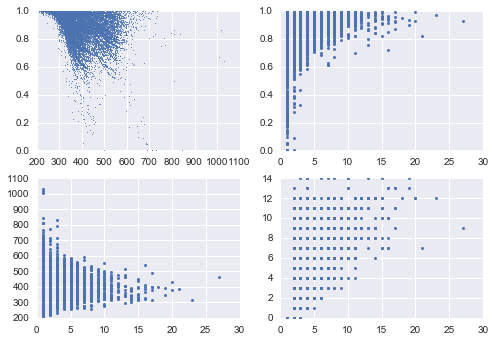

In [77]:
plt.subplot(2,2,1)
plt.plot(df.mean_pace,df.mean_rank,marker='o',markersize=1,linestyle='None')
plt.subplot(2,2,2)
plt.plot(df.races,df.mean_rank,marker='o',markersize=3,linestyle='None')
plt.subplot(2,2,3)
plt.plot(df.races,df.mean_pace,marker='o',markersize=3,linestyle='None')
plt.subplot(2,2,4)
plt.plot(df.races,df.max_age-df.min_age,marker='o',markersize=3,linestyle='None')

In [148]:
import sklearn.cluster
Nclusters = 2
mbkmeans = sklearn.cluster.MiniBatchKMeans(Nclusters)

In [149]:
# by now: only by pace
y = np.array(range(len(names))) # response variable
X = np.array(mean_pace)
X = X.reshape(-1, 1)
Y = mbkmeans.fit_predict(X)

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1279: DeprecationWarning: This function is deprecated. Please call randint(0, 7058 + 1) instead
  0, n_samples - 1, init_size)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 7058 + 1) instead
  0, n_samples - 1, init_size)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 7058 + 1) instead
  0, n_samples - 1, init_size)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:630: DeprecationWarning: This function is deprecated. Please call randint(0, 7058 + 1) instead
  0, n_samples - 1, init_size)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:1328: DeprecationWarning: This function is deprecated. Please call randint(0, 7058 + 1) instead
  0, n_samples - 1, self.batch_size)
C:

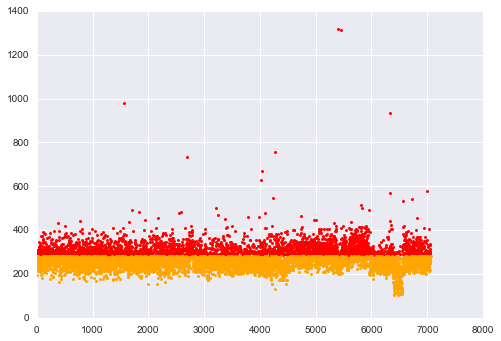

In [150]:
dd = pd.DataFrame({'name' : names, 'mean_pace' : mean_pace, 'mean_pace_rate' : mean_pace_rate, 'cluster' : Y}) # for viz
plt.plot(dd.mean_pace[dd.cluster==0],marker='o',markersize=3,c='red',linestyle='None')
plt.plot(dd.mean_pace[dd.cluster==1],marker='o',markersize=3,c='orange',linestyle='None')
plt.plot(dd.mean_pace[dd.cluster==2],marker='o',markersize=3,c='pink',linestyle='None')
plt.plot(dd.mean_pace[dd.cluster==3],marker='o',markersize=3,c='blue',linestyle='None')

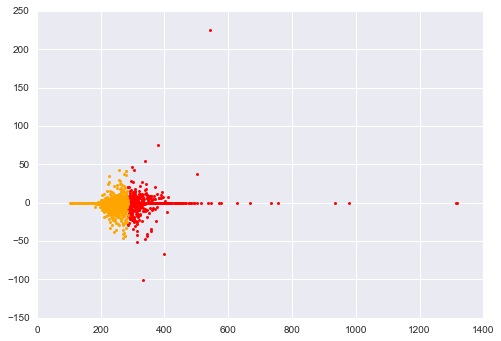

In [151]:
plt.plot(dd.mean_pace[dd.cluster==0],dd.mean_pace_rate[dd.cluster==0],marker='o',markersize=3,c='red',linestyle='None')
plt.plot(dd.mean_pace[dd.cluster==1],dd.mean_pace_rate[dd.cluster==1],marker='o',markersize=3,c='orange',linestyle='None')
plt.plot(dd.mean_pace[dd.cluster==2],dd.mean_pace_rate[dd.cluster==2],marker='o',markersize=3,c='pink',linestyle='None')
plt.plot(dd.mean_pace[dd.cluster==3],dd.mean_pace_rate[dd.cluster==3],marker='o',markersize=3,c='blue',linestyle='None')